In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import random
import math

In [102]:
# Hyperparameters
ENV_NAME = 'Pendulum-v1'
STATE_DIM = 3
ACTION_DIM = 1
HIDDEN_DIM = 256
BUFFER_SIZE = 100000
BATCH_SIZE = 256
GAMMA = 0.99
TAU = 0.005
LR_ACTOR = 0.0003
LR_CRITIC = 0.0003
LR_ALPHA = 0.00001  # 进一步降低学习率以减少震荡
ALPHA_INIT = 0.2
MAX_EPISODES = 300
MAX_STEPS = 100
EVAL_INTERVAL = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [103]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch)) 
        
        return (
            torch.FloatTensor(state).to(DEVICE),
            torch.FloatTensor(action).to(DEVICE),
            torch.FloatTensor(reward).unsqueeze(1).to(DEVICE),
            torch.FloatTensor(next_state).to(DEVICE),
            torch.FloatTensor(done).unsqueeze(1).to(DEVICE)
        )

    def __len__(self):
        return len(self.buffer)

In [104]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

In [105]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)  # 限制 log_std 范围以提高稳定性
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        z = normal.rsample()  # 重参数化技巧
        action = torch.tanh(z)
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob

第 0 轮, 平均奖励: -680.63, 平均熵: 68.14, Alpha: 0.2000
第 10 轮, 平均奖励: -719.59, 平均熵: 18.03, Alpha: 0.2022
第 20 轮, 平均奖励: -394.22, 平均熵: -60.14, Alpha: 0.2049
第 30 轮, 平均奖励: -484.00, 平均熵: -98.93, Alpha: 0.2077
第 40 轮, 平均奖励: -195.06, 平均熵: -70.69, Alpha: 0.2101
第 50 轮, 平均奖励: -63.35, 平均熵: -60.84, Alpha: 0.2124
第 60 轮, 平均奖励: -241.98, 平均熵: -73.48, Alpha: 0.2145
第 70 轮, 平均奖励: -178.62, 平均熵: -43.98, Alpha: 0.2167
第 80 轮, 平均奖励: -60.06, 平均熵: -3.07, Alpha: 0.2189
第 90 轮, 平均奖励: -118.49, 平均熵: -6.60, Alpha: 0.2211
第 100 轮, 平均奖励: -177.65, 平均熵: -123.34, Alpha: 0.2234
第 110 轮, 平均奖励: -121.90, 平均熵: 11.30, Alpha: 0.2255
第 120 轮, 平均奖励: -127.79, 平均熵: -26.10, Alpha: 0.2278
第 130 轮, 平均奖励: -222.76, 平均熵: -30.91, Alpha: 0.2300
第 140 轮, 平均奖励: -120.52, 平均熵: 12.44, Alpha: 0.2323
第 150 轮, 平均奖励: -270.89, 平均熵: -58.40, Alpha: 0.2345
第 160 轮, 平均奖励: -181.72, 平均熵: -57.35, Alpha: 0.2368
第 170 轮, 平均奖励: -119.97, 平均熵: 14.82, Alpha: 0.2391
第 180 轮, 平均奖励: -124.86, 平均熵: 34.17, Alpha: 0.2413
第 190 轮, 平均奖励: -121.21, 平均熵: 6.17, Alpha: 0.2436
第 

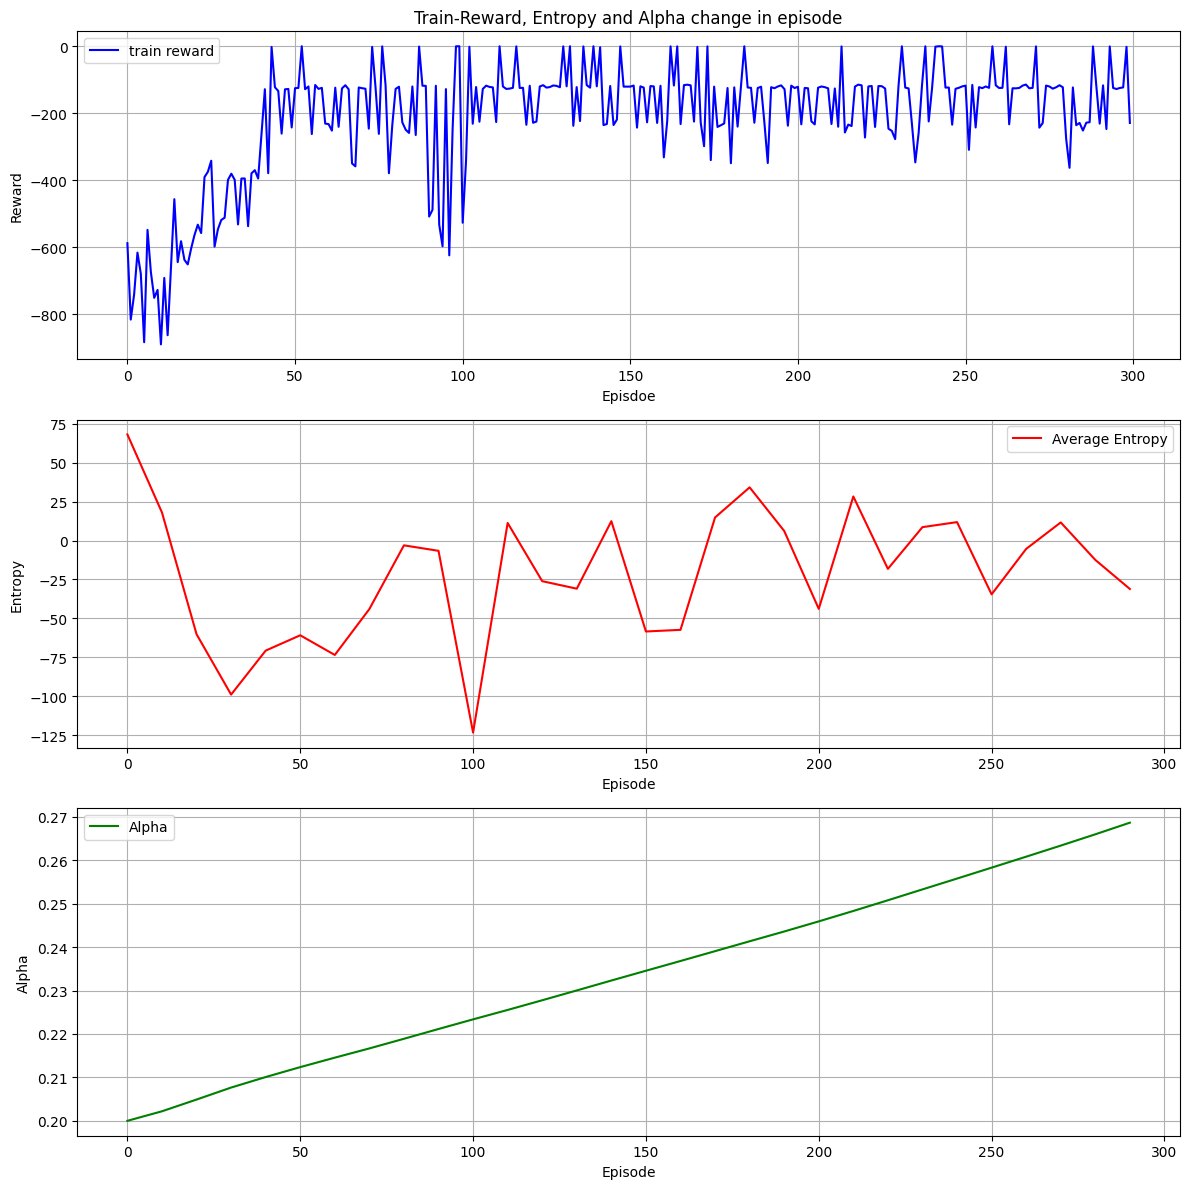

In [106]:
class SACAgent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.buffer = ReplayBuffer(BUFFER_SIZE)
        self.action_dim = ACTION_DIM
        self.actor = PolicyNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.critic1 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.critic2 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic1 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic2 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=LR_CRITIC)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=LR_CRITIC)
        
        self.log_alpha = torch.tensor(np.log(ALPHA_INIT), requires_grad=True, device=DEVICE)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=LR_ALPHA)
        
        self.target_entropy = -math.log(2*ACTION_DIM) # 设置目标熵为最大熵
        self.total_steps = 0
    
    def select_action(self, state, deterministic=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            if deterministic:
                mean, _ = self.actor(state)
                action = torch.tanh(mean)
            else: 
                action, _ = self.actor.sample(state)
            
        return action.cpu().numpy()[0]
    
    def update(self):
        if len(self.buffer) < BATCH_SIZE:
            return
        state, action, reward, next_state, done = self.buffer.sample(BATCH_SIZE)

        # Update Critics
        with torch.no_grad():
            next_action, next_log_prob = self.actor.sample(next_state)
            q1_next = self.target_critic1(next_state, next_action)
            q2_next = self.target_critic2(next_state, next_action)
            q_next = torch.min(q1_next, q2_next)
            alpha = self.log_alpha.exp()
            # next_log_prob越大，概率越小。target_q值越大。鼓励小概率事件
            target_q = reward + (1 - done) * GAMMA * (q_next - alpha * next_log_prob)
        
        q1 = self.critic1(state, action)
        q2 = self.critic2(state, action)
        critic1_loss = F.mse_loss(q1, target_q)
        critic2_loss = F.mse_loss(q2, target_q)
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        
        # Update Actor
        with torch.no_grad():
            alpha = self.log_alpha.exp() # 避免梯度干扰
        action_new, log_prob = self.actor.sample(state)
        q1_new = self.critic1(state, action_new)
        q2_new = self.critic1(state, action_new)
        q_new = torch.min(q1_new, q2_new)
        # alpha * log_prob 概率越小，该项越小（负数），损失越小。鼓励小概率事件
        actor_loss = (alpha * log_prob - q_new).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # 更新 Alpha
        alpha_loss = -(self.log_alpha.exp() * (log_prob - self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # 添加约束，防止 alpha 过大或过小
        with torch.no_grad():
            self.log_alpha.clamp_(min=-2, max=2) # alpha 在 [e^-2, e^2] 范围内，约为 [0.135, 7.389]
            
        # 软更新目标网络
        for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
        for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
                
    def train(self):
        rewards = []
        entropies = []
        alphas = []  # 添加 alpha 的记录
        for episode in range(MAX_EPISODES):
            state, _ = self.env.reset()
            episode_reward = 0
            for step in range(MAX_STEPS):
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action*2) # Pendulum action range [-2, 2]
                self.buffer.push(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                self.total_steps += 1
                self.update()
                if done:
                    break 
            rewards.append(episode_reward)
            if episode % EVAL_INTERVAL == 0:
                avg_reward, avg_entropy = self.evaluate()
                avg_alpha = self.log_alpha.exp().item()
                print(f"第 {episode} 轮, 平均奖励: {avg_reward:.2f}, 平均熵: {avg_entropy:.2f}, Alpha: {avg_alpha:.4f}")
                entropies.append(avg_entropy)
                alphas.append(avg_alpha)
        
        self.plot_results(rewards, entropies, alphas)
        

    def evaluate(self):
        env = gym.make(ENV_NAME)
        total_reward = 0
        total_entropy = 0
        episodes = 2
        for _ in range(episodes):
            state, _ = env.reset()
            episode_reward = 0
            episode_entropy = 0
            for _ in range(MAX_STEPS):
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
                with torch.no_grad():
                    action, log_prob = self.actor.sample(state_tensor)
                action = action.cpu().numpy()[0]
                next_state, reward, done, _, _ = env.step(action * 2)
                state = next_state
                episode_reward += reward
                episode_entropy += -log_prob.mean().item()
                if done:
                     break
            total_reward += episode_reward
            total_entropy += episode_entropy
        env.close()
        return total_reward / episodes, total_entropy / episodes
    
    def plot_results(self, rewards, entropies, alphas):
        plt.figure(figsize=(12, 12))
        
        # 奖励图
        plt.subplot(3, 1, 1)
        episodes = range(0, MAX_EPISODES, 1)
        plt.plot(episodes, rewards, 'b-', label='train reward')
        plt.title('Train-Reward, Entropy and Alpha change in episode')
        plt.xlabel('Episdoe')
        plt.ylabel('Reward')
        plt.grid(True)
        plt.legend()
        
        # Entropy Plot
        plt.subplot(3, 1, 2)
        eval_episodes = range(0, MAX_EPISODES, EVAL_INTERVAL)
        plt.plot(eval_episodes, entropies, 'r-', label='Average Entropy')
        plt.xlabel('Episode')
        plt.ylabel('Entropy')
        plt.grid(True)
        plt.legend()
        
        # Alpha 图
        plt.subplot(3, 1, 3)
        plt.plot(eval_episodes, alphas, 'g-', label='Alpha')
        plt.xlabel('Episode')
        plt.ylabel('Alpha')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_results.png')
        
    def test(self):
        env = gym.make(ENV_NAME, render_mode="human") 
        state, _ = env.reset()
        total_reward = 0
        for _ in range(MAX_STEPS):
            action = self.select_action(state, deterministic=True)
            next_state, reward, done, _, _ = env.step(action*2)
            state = next_state
            total_reward += reward
            env.render()
            if done: 
                break 
        env.close()
        print(f"测试奖励: {total_reward:.2f}")
        
# 训练和测试
agent = SACAgent()
agent.train()
agent.test()

---

# 完整代码如下：


调整alpha损失计算方式：

```python
# 重新调整self.target_entropy
self.target_entropy = -action_dim
alpha_loss = -(self.log_alpha.exp() * (log_prob + self.target_entropy).detach()).mean()
```

第 0 轮, 平均奖励: -8941.34, 平均熵: 564.98, Alpha: 0.1986
第 10 轮, 平均奖励: -122.07, 平均熵: 293.82, Alpha: 0.1882
第 20 轮, 平均奖励: -230.24, 平均熵: 305.68, Alpha: 0.1694
第 30 轮, 平均奖励: -181.79, 平均熵: 248.37, Alpha: 0.1539
第 40 轮, 平均奖励: -185.53, 平均熵: 376.75, Alpha: 0.1391
第 50 轮, 平均奖励: -180.43, 平均熵: 367.88, Alpha: 0.1259
第 60 轮, 平均奖励: -191.43, 平均熵: 274.33, Alpha: 0.1141
第 70 轮, 平均奖励: -124.59, 平均熵: 380.97, Alpha: 0.1033
第 80 轮, 平均奖励: -183.49, 平均熵: 368.14, Alpha: 0.0936
第 90 轮, 平均奖励: -127.55, 平均熵: 381.90, Alpha: 0.0848
第 100 轮, 平均奖励: -233.20, 平均熵: 304.34, Alpha: 0.0768
第 110 轮, 平均奖励: -124.98, 平均熵: 306.66, Alpha: 0.0695
第 120 轮, 平均奖励: -64.15, 平均熵: 399.32, Alpha: 0.0629
第 130 轮, 平均奖励: -127.80, 平均熵: 275.79, Alpha: 0.0570
第 140 轮, 平均奖励: -295.03, 平均熵: 247.50, Alpha: 0.0516
第 150 轮, 平均奖励: -173.24, 平均熵: 308.49, Alpha: 0.0468
第 160 轮, 平均奖励: -130.09, 平均熵: 355.38, Alpha: 0.0424
第 170 轮, 平均奖励: -120.41, 平均熵: 347.04, Alpha: 0.0384
第 180 轮, 平均奖励: -180.52, 平均熵: 277.60, Alpha: 0.0348
第 190 轮, 平均奖励: -120.07, 平均熵: 296.59, Alpha

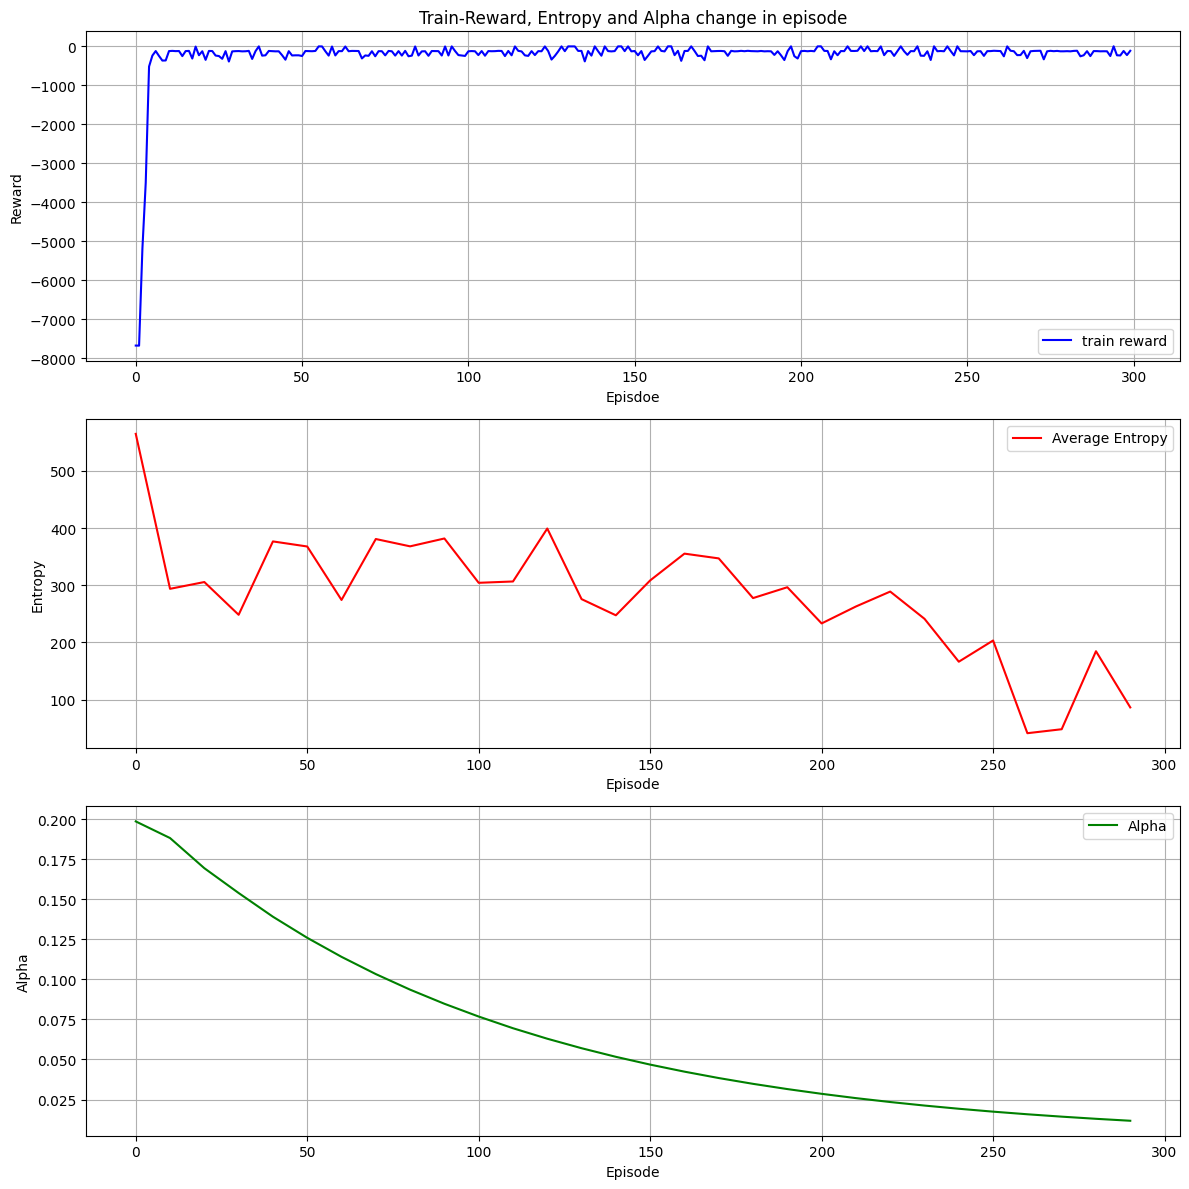

In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import random
import math

# Hyperparameters
ENV_NAME = 'Pendulum-v1'
STATE_DIM = 3  # LunarLanderContinuous-v3 状态维度
ACTION_DIM = 1  # 两个连续动作
HIDDEN_DIM = 256
BUFFER_SIZE = 100000
BATCH_SIZE = 256
GAMMA = 0.99
TAU = 0.005
LR_ACTOR = 0.0003
LR_CRITIC = 0.0003
LR_ALPHA = 0.00001
ALPHA_INIT = 0.2
MAX_EPISODES = 300
MAX_STEPS = 1000  # LunarLander 每回合最多 1000 步
EVAL_INTERVAL = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch)) 
        
        return (
            torch.FloatTensor(state).to(DEVICE),
            torch.FloatTensor(action).to(DEVICE),
            torch.FloatTensor(reward).unsqueeze(1).to(DEVICE),
            torch.FloatTensor(next_state).to(DEVICE),
            torch.FloatTensor(done).unsqueeze(1).to(DEVICE)
        )

    def __len__(self):
        return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value
    

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)  # 限制 log_std 范围以提高稳定性
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        z = normal.rsample()  # 重参数化技巧
        action = torch.tanh(z)
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob
    
    
class SACAgent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.buffer = ReplayBuffer(BUFFER_SIZE)
        self.action_dim = ACTION_DIM
        self.actor = PolicyNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.critic1 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.critic2 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic1 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic2 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=LR_CRITIC)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=LR_CRITIC)
        
        self.log_alpha = torch.tensor(np.log(ALPHA_INIT), requires_grad=True, device=DEVICE)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=LR_ALPHA)
        
        self.target_entropy = -ACTION_DIM # 设置目标熵为最大熵
        self.total_steps = 0
    
    def select_action(self, state, deterministic=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            if deterministic:
                mean, _ = self.actor(state)
                action = torch.tanh(mean)
            else: 
                action, _ = self.actor.sample(state)
            
        return action.cpu().numpy()[0]
    
    def update(self):
        if len(self.buffer) < BATCH_SIZE:
            return
        state, action, reward, next_state, done = self.buffer.sample(BATCH_SIZE)

        # Update Critics
        with torch.no_grad():
            next_action, next_log_prob = self.actor.sample(next_state)
            q1_next = self.target_critic1(next_state, next_action)
            q2_next = self.target_critic2(next_state, next_action)
            q_next = torch.min(q1_next, q2_next)
            alpha = self.log_alpha.exp()
            # next_log_prob越大，概率越小。target_q值越大。鼓励小概率事件
            target_q = reward + (1 - done) * GAMMA * (q_next - alpha * next_log_prob)
        
        q1 = self.critic1(state, action)
        q2 = self.critic2(state, action)
        critic1_loss = F.mse_loss(q1, target_q)
        critic2_loss = F.mse_loss(q2, target_q)
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        
        # Update Actor
        with torch.no_grad():
            alpha = self.log_alpha.exp() # 避免梯度干扰
        action_new, log_prob = self.actor.sample(state)
        q1_new = self.critic1(state, action_new)
        q2_new = self.critic1(state, action_new)
        q_new = torch.min(q1_new, q2_new)
        # alpha * log_prob 概率越小，该项越小（负数），损失越小。鼓励小概率事件
        actor_loss = (alpha * log_prob - q_new).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # 更新 Alpha
        alpha_loss = -(self.log_alpha.exp() * (log_prob + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # 添加约束，防止 alpha 过大或过小
        with torch.no_grad():
            self.log_alpha.clamp_(min=-5, max=5) # alpha 在 [e^-2, e^2] 范围内，约为 [0.135, 7.389]
            
        # 软更新目标网络
        for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
        for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
                
    def train(self):
        rewards = []
        entropies = []
        alphas = []  # 添加 alpha 的记录
        for episode in range(MAX_EPISODES):
            state, _ = self.env.reset()
            episode_reward = 0
            for step in range(MAX_STEPS):
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action*2) # Pendulum action range [-2, 2]
                self.buffer.push(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                self.total_steps += 1
                self.update()
                if done:
                    break 
            rewards.append(episode_reward)
            if episode % EVAL_INTERVAL == 0:
                avg_reward, avg_entropy = self.evaluate()
                avg_alpha = self.log_alpha.exp().item()
                print(f"第 {episode} 轮, 平均奖励: {avg_reward:.2f}, 平均熵: {avg_entropy:.2f}, Alpha: {avg_alpha:.4f}")
                entropies.append(avg_entropy)
                alphas.append(avg_alpha)
        
        self.plot_results(rewards, entropies, alphas)
        

    def evaluate(self):
        env = gym.make(ENV_NAME)
        total_reward = 0
        total_entropy = 0
        episodes = 2
        for _ in range(episodes):
            state, _ = env.reset()
            episode_reward = 0
            episode_entropy = 0
            for _ in range(MAX_STEPS):
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
                with torch.no_grad():
                    action, log_prob = self.actor.sample(state_tensor)
                action = action.cpu().numpy()[0]
                next_state, reward, done, _, _ = env.step(action * 2)
                state = next_state
                episode_reward += reward
                episode_entropy += -log_prob.mean().item()
                if done:
                     break
            total_reward += episode_reward
            total_entropy += episode_entropy
        env.close()
        return total_reward / episodes, total_entropy / episodes
    
    def plot_results(self, rewards, entropies, alphas):
        plt.figure(figsize=(12, 12))
        
        # 奖励图
        plt.subplot(3, 1, 1)
        episodes = range(0, MAX_EPISODES, 1)
        plt.plot(episodes, rewards, 'b-', label='train reward')
        plt.title('Train-Reward, Entropy and Alpha change in episode')
        plt.xlabel('Episdoe')
        plt.ylabel('Reward')
        plt.grid(True)
        plt.legend()
        
        # Entropy Plot
        plt.subplot(3, 1, 2)
        eval_episodes = range(0, MAX_EPISODES, EVAL_INTERVAL)
        plt.plot(eval_episodes, entropies, 'r-', label='Average Entropy')
        plt.xlabel('Episode')
        plt.ylabel('Entropy')
        plt.grid(True)
        plt.legend()
        
        # Alpha 图
        plt.subplot(3, 1, 3)
        plt.plot(eval_episodes, alphas, 'g-', label='Alpha')
        plt.xlabel('Episode')
        plt.ylabel('Alpha')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_results.png')
        
    def test(self):
        env = gym.make(ENV_NAME, render_mode="human") 
        state, _ = env.reset()
        total_reward = 0
        for _ in range(MAX_STEPS):
            action = self.select_action(state, deterministic=True)
            next_state, reward, done, _, _ = env.step(action*2)
            state = next_state
            total_reward += reward
            env.render()
            if done: 
                break 
        env.close()
        print(f"测试奖励: {total_reward:.2f}")
        
# 训练和测试
agent = SACAgent()
agent.train()
agent.test()

In [ ]:
agent.test()

---

# 调整游戏环境测试

调整alpha损失计算方式：

```python
# 重新调整self.target_entropy
self.target_entropy = -action_dim
alpha_loss = -(self.log_alpha.exp() * (log_prob + self.target_entropy).detach()).mean()
```

第 0 轮, 平均奖励: -236.08, 平均熵: 173.62, Alpha: 0.2000
第 10 轮, 平均奖励: -166.04, 平均熵: -102.13, Alpha: 0.1986
第 20 轮, 平均奖励: -189.11, 平均熵: 118.53, Alpha: 0.1940
第 30 轮, 平均奖励: -44.92, 平均熵: -135.01, Alpha: 0.1917
第 40 轮, 平均奖励: -223.65, 平均熵: -215.48, Alpha: 0.1953
第 50 轮, 平均奖励: -64.15, 平均熵: -91.18, Alpha: 0.1972
第 60 轮, 平均奖励: -231.13, 平均熵: -103.53, Alpha: 0.1992
第 70 轮, 平均奖励: -195.56, 平均熵: -122.69, Alpha: 0.1941
第 80 轮, 平均奖励: 15.29, 平均熵: -1153.98, Alpha: 0.1852
第 90 轮, 平均奖励: 148.98, 平均熵: -736.44, Alpha: 0.1771
第 100 轮, 平均奖励: 180.21, 平均熵: -826.48, Alpha: 0.1748
第 110 轮, 平均奖励: -12.99, 平均熵: -462.78, Alpha: 0.1637
第 120 轮, 平均奖励: -71.46, 平均熵: -112.57, Alpha: 0.1516
第 130 轮, 平均奖励: 32.79, 平均熵: -623.50, Alpha: 0.1467
第 140 轮, 平均奖励: 7.73, 平均熵: -1288.40, Alpha: 0.1481
第 150 轮, 平均奖励: 49.38, 平均熵: -179.98, Alpha: 0.1465
第 160 轮, 平均奖励: 145.07, 平均熵: -339.97, Alpha: 0.1442
第 170 轮, 平均奖励: 77.38, 平均熵: -236.32, Alpha: 0.1417
第 180 轮, 平均奖励: 259.99, 平均熵: -369.58, Alpha: 0.1416
第 190 轮, 平均奖励: 102.18, 平均熵: -179.75, Alpha:

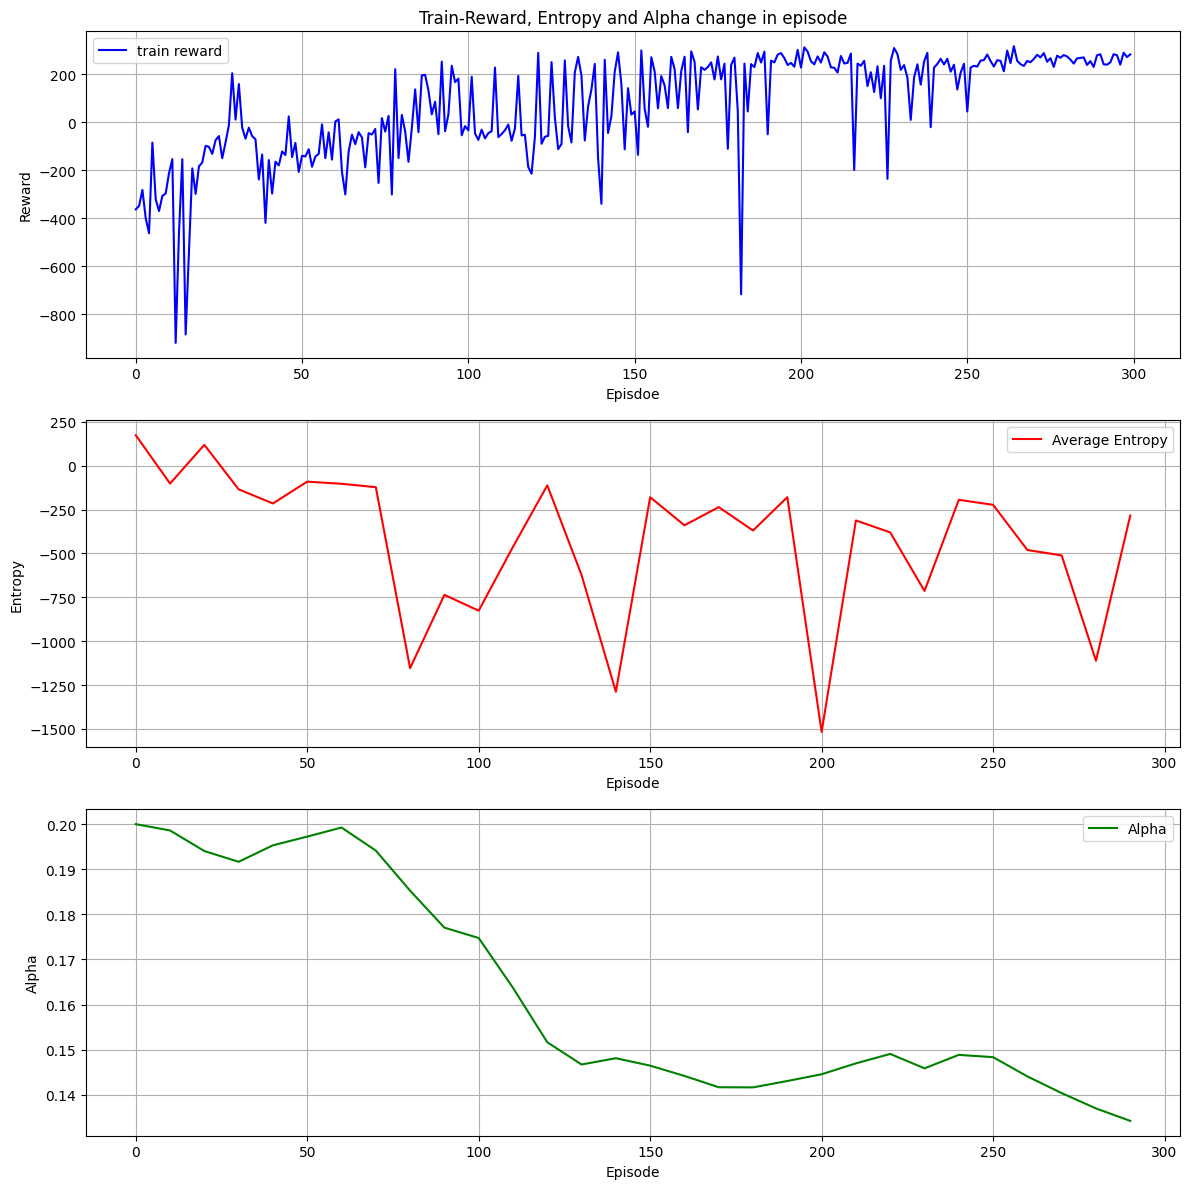

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import random
import math

# 超参数
ENV_NAME = 'LunarLanderContinuous-v3'
STATE_DIM = 8  # LunarLanderContinuous-v3 状态维度
ACTION_DIM = 2  # 两个连续动作
HIDDEN_DIM = 256
BUFFER_SIZE = 100000
BATCH_SIZE = 256
GAMMA = 0.99
TAU = 0.005
LR_ACTOR = 0.0003
LR_CRITIC = 0.0003
LR_ALPHA = 0.00001
ALPHA_INIT = 0.2
MAX_EPISODES = 300
MAX_STEPS = 1000  # LunarLander 每回合最多 1000 步
EVAL_INTERVAL = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch)) 
        
        return (
            torch.FloatTensor(state).to(DEVICE),
            torch.FloatTensor(action).to(DEVICE),
            torch.FloatTensor(reward).unsqueeze(1).to(DEVICE),
            torch.FloatTensor(next_state).to(DEVICE),
            torch.FloatTensor(done).unsqueeze(1).to(DEVICE)
        )

    def __len__(self):
        return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value
    

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)  # 限制 log_std 范围以提高稳定性
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        z = normal.rsample()  # 重参数化技巧
        action = torch.tanh(z)
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob
    
    
class SACAgent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.buffer = ReplayBuffer(BUFFER_SIZE)
        self.action_dim = ACTION_DIM
        self.actor = PolicyNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.critic1 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.critic2 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic1 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic2 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=LR_CRITIC)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=LR_CRITIC)
        
        self.log_alpha = torch.tensor(np.log(ALPHA_INIT), requires_grad=True, device=DEVICE)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=LR_ALPHA)
        
        self.target_entropy = -ACTION_DIM # 设置目标熵为最大熵
        self.total_steps = 0
    
    def select_action(self, state, deterministic=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            if deterministic:
                mean, _ = self.actor(state)
                action = torch.tanh(mean)
            else: 
                action, _ = self.actor.sample(state)
            
        return action.cpu().numpy()[0]
    
    def update(self):
        if len(self.buffer) < BATCH_SIZE:
            return
        state, action, reward, next_state, done = self.buffer.sample(BATCH_SIZE)

        # Update Critics
        with torch.no_grad():
            next_action, next_log_prob = self.actor.sample(next_state)
            q1_next = self.target_critic1(next_state, next_action)
            q2_next = self.target_critic2(next_state, next_action)
            q_next = torch.min(q1_next, q2_next)
            alpha = self.log_alpha.exp()
            # next_log_prob越大，概率越小。target_q值越大。鼓励小概率事件
            target_q = reward + (1 - done) * GAMMA * (q_next - alpha * next_log_prob)
        
        q1 = self.critic1(state, action)
        q2 = self.critic2(state, action)
        critic1_loss = F.mse_loss(q1, target_q)
        critic2_loss = F.mse_loss(q2, target_q)
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        
        # Update Actor
        with torch.no_grad():
            alpha = self.log_alpha.exp() # 避免梯度干扰
        action_new, log_prob = self.actor.sample(state)
        q1_new = self.critic1(state, action_new)
        q2_new = self.critic1(state, action_new)
        q_new = torch.min(q1_new, q2_new)
        # alpha * log_prob 概率越小，该项越小（负数），损失越小。鼓励小概率事件
        actor_loss = (alpha * log_prob - q_new).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # 更新 Alpha
        alpha_loss = -(self.log_alpha.exp() * (log_prob + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # 添加约束，防止 alpha 过大或过小
        with torch.no_grad():
            self.log_alpha.clamp_(min=-5, max=5) # alpha 在 [e^-2, e^2] 范围内，约为 [0.135, 7.389]
            
        # 软更新目标网络
        for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
        for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
                
    def train(self):
        rewards = []
        entropies = []
        alphas = []  # 添加 alpha 的记录
        for episode in range(MAX_EPISODES):
            state, _ = self.env.reset()
            episode_reward = 0
            for step in range(MAX_STEPS):
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action*2) # Pendulum action range [-2, 2]
                self.buffer.push(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                self.total_steps += 1
                self.update()
                if done:
                    break 
            rewards.append(episode_reward)
            if episode % EVAL_INTERVAL == 0:
                avg_reward, avg_entropy = self.evaluate()
                avg_alpha = self.log_alpha.exp().item()
                print(f"第 {episode} 轮, 平均奖励: {avg_reward:.2f}, 平均熵: {avg_entropy:.2f}, Alpha: {avg_alpha:.4f}")
                entropies.append(avg_entropy)
                alphas.append(avg_alpha)
        
        self.plot_results(rewards, entropies, alphas)
        

    def evaluate(self):
        env = gym.make(ENV_NAME)
        total_reward = 0
        total_entropy = 0
        episodes = 2
        for _ in range(episodes):
            state, _ = env.reset()
            episode_reward = 0
            episode_entropy = 0
            for _ in range(MAX_STEPS):
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
                with torch.no_grad():
                    action, log_prob = self.actor.sample(state_tensor)
                action = action.cpu().numpy()[0]
                next_state, reward, done, _, _ = env.step(action * 2)
                state = next_state
                episode_reward += reward
                episode_entropy += -log_prob.mean().item()
                if done:
                     break
            total_reward += episode_reward
            total_entropy += episode_entropy
        env.close()
        return total_reward / episodes, total_entropy / episodes
    
    def plot_results(self, rewards, entropies, alphas):
        plt.figure(figsize=(12, 12))
        
        # 奖励图
        plt.subplot(3, 1, 1)
        episodes = range(0, MAX_EPISODES, 1)
        plt.plot(episodes, rewards, 'b-', label='train reward')
        plt.title('Train-Reward, Entropy and Alpha change in episode')
        plt.xlabel('Episdoe')
        plt.ylabel('Reward')
        plt.grid(True)
        plt.legend()
        
        # Entropy Plot
        plt.subplot(3, 1, 2)
        eval_episodes = range(0, MAX_EPISODES, EVAL_INTERVAL)
        plt.plot(eval_episodes, entropies, 'r-', label='Average Entropy')
        plt.xlabel('Episode')
        plt.ylabel('Entropy')
        plt.grid(True)
        plt.legend()
        
        # Alpha 图
        plt.subplot(3, 1, 3)
        plt.plot(eval_episodes, alphas, 'g-', label='Alpha')
        plt.xlabel('Episode')
        plt.ylabel('Alpha')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_results.png')
        
    def test(self):
        env = gym.make(ENV_NAME, render_mode="human") 
        state, _ = env.reset()
        total_reward = 0
        for _ in range(MAX_STEPS):
            action = self.select_action(state, deterministic=True)
            next_state, reward, done, _, _ = env.step(action*2)
            state = next_state
            total_reward += reward
            env.render()
            if done: 
                break 
        env.close()
        print(f"测试奖励: {total_reward:.2f}")
        
# 训练和测试
agent = SACAgent()
agent.train()
agent.test()

In [151]:
agent.test()

测试奖励: 271.27


第 0 轮, 平均奖励: -288.13, 平均熵: 128.02, Alpha: 0.2000, Target Entropy: -1.3863
第 10 轮, 平均奖励: -70.96, 平均熵: 6.36, Alpha: 0.2003, Target Entropy: -1.2939
第 20 轮, 平均奖励: -11.80, 平均熵: -141.57, Alpha: 0.2009, Target Entropy: -1.2104
第 30 轮, 平均奖励: -169.38, 平均熵: 62.52, Alpha: 0.2017, Target Entropy: -1.1348
第 40 轮, 平均奖励: -63.73, 平均熵: -61.59, Alpha: 0.2024, Target Entropy: -1.0664
第 50 轮, 平均奖励: -268.22, 平均熵: -243.74, Alpha: 0.2028, Target Entropy: -1.0045
第 60 轮, 平均奖励: -444.48, 平均熵: -594.08, Alpha: 0.2034, Target Entropy: -0.9485
第 70 轮, 平均奖励: -70.46, 平均熵: -36.56, Alpha: 0.2037, Target Entropy: -0.8978
第 80 轮, 平均奖励: -132.98, 平均熵: -8.96, Alpha: 0.2042, Target Entropy: -0.8519
第 90 轮, 平均奖励: -354.11, 平均熵: -171.65, Alpha: 0.2051, Target Entropy: -0.8104
第 100 轮, 平均奖励: 97.69, 平均熵: -255.78, Alpha: 0.2059, Target Entropy: -0.7729
第 110 轮, 平均奖励: -54.57, 平均熵: 87.15, Alpha: 0.2070, Target Entropy: -0.7389
第 120 轮, 平均奖励: 23.69, 平均熵: 459.80, Alpha: 0.2085, Target Entropy: -0.7082
第 130 轮, 平均奖励: -65.53, 平均熵: 33.9

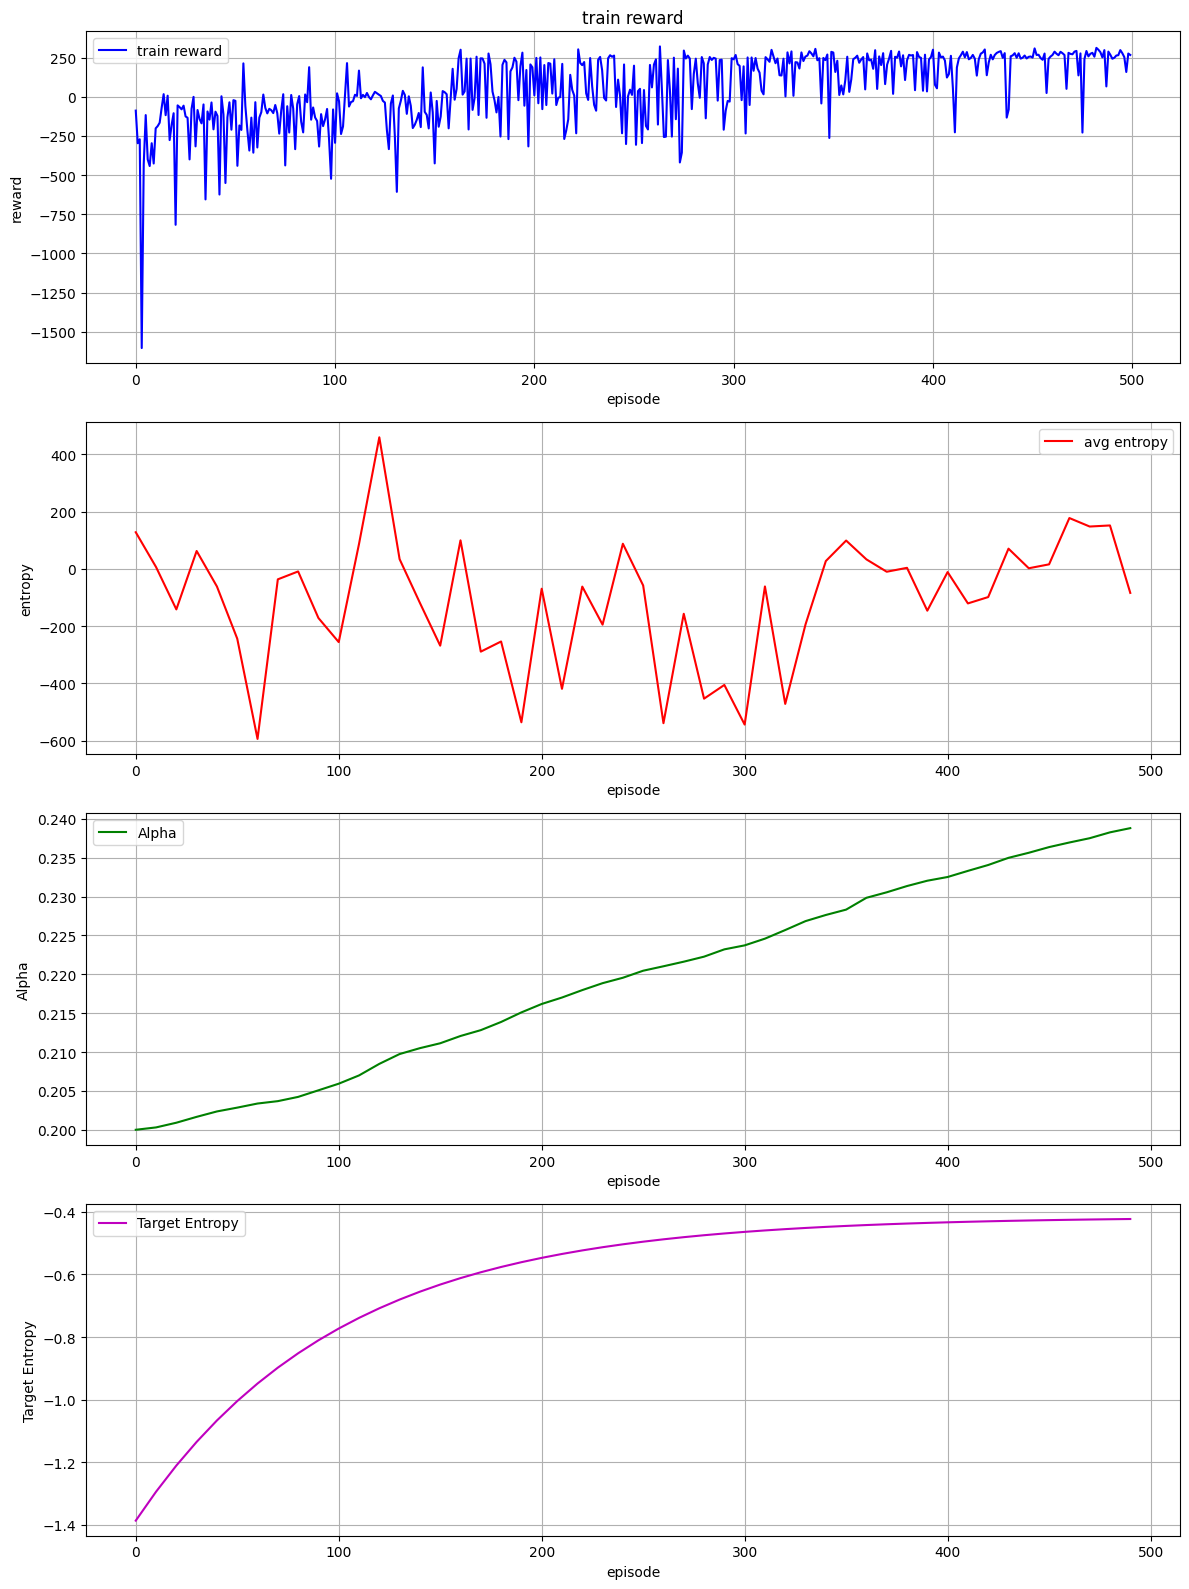

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import random
import math

# 超参数
ENV_NAME = 'LunarLanderContinuous-v3'
STATE_DIM = 8  # LunarLanderContinuous-v3 状态维度
ACTION_DIM = 2  # 两个连续动作
HIDDEN_DIM = 256
BUFFER_SIZE = 100000
BATCH_SIZE = 256
GAMMA = 0.99
TAU = 0.005
LR_ACTOR = 0.001
LR_CRITIC = 0.001
LR_ALPHA = 0.000001
ALPHA_INIT = 0.2
MAX_EPISODES = 500
MAX_STEPS = 800  # LunarLander 每回合最多 1000 步
EVAL_INTERVAL = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch)) 
        
        return (
            torch.FloatTensor(state).to(DEVICE),
            torch.FloatTensor(action).to(DEVICE),
            torch.FloatTensor(reward).unsqueeze(1).to(DEVICE),
            torch.FloatTensor(next_state).to(DEVICE),
            torch.FloatTensor(done).unsqueeze(1).to(DEVICE)
        )

    def __len__(self):
        return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        z = normal.rsample()
        action = torch.tanh(z)  # 动作范围 [-1, 1]
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob
    
class SACAgent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.buffer = ReplayBuffer(BUFFER_SIZE)
        self.action_dim = ACTION_DIM
        self.actor = PolicyNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.critic1 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.critic2 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic1 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic2 = QNetwork(STATE_DIM, ACTION_DIM, HIDDEN_DIM).to(DEVICE)
        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=LR_CRITIC)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=LR_CRITIC)
        
        self.log_alpha = torch.tensor(np.log(ALPHA_INIT), requires_grad=True, device=DEVICE)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=LR_ALPHA)
        
        self.initial_entropy = -math.log(2 * ACTION_DIM)
        self.final_entropy = self.initial_entropy * 0.3
        self.decay_rate = 5.0
        self.target_entropy = self.initial_entropy
        self.total_steps = 0
        self.smoothed_diff = 0.0
        self.beta = 0.9
    
    def select_action(self, state, deterministic=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            if deterministic:
                mean, _ = self.actor(state)
                action = torch.tanh(mean)
            else: 
                action, _ = self.actor.sample(state)
            
        return action.cpu().numpy()[0]
    
    def update(self):
        if len(self.buffer) < BATCH_SIZE:
            return
        state, action, reward, next_state, done = self.buffer.sample(BATCH_SIZE)

        with torch.no_grad():
            next_action, next_log_prob = self.actor.sample(next_state)
            q1_next = self.target_critic1(next_state, next_action)
            q2_next = self.target_critic2(next_state, next_action)
            q_next = torch.min(q1_next, q2_next)
            alpha = self.log_alpha.exp()
            target_q = reward + (1 - done) * GAMMA * (q_next - alpha * next_log_prob)
        
        q1 = self.critic1(state, action)
        q2 = self.critic2(state, action)
        critic1_loss = F.mse_loss(q1, target_q)
        critic2_loss = F.mse_loss(q2, target_q)
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        
        with torch.no_grad():
            alpha = self.log_alpha.exp()
        action_new, log_prob = self.actor.sample(state)
        q1_new = self.critic1(state, action_new)
        q2_new = self.critic2(state, action_new)
        q_new = torch.min(q1_new, q2_new)
        actor_loss = (alpha * log_prob - q_new).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        diff = (log_prob - self.target_entropy).detach().mean().item()
        self.smoothed_diff = self.beta * self.smoothed_diff + (1 - self.beta) * diff
        alpha_loss = -(self.log_alpha.exp() * self.smoothed_diff)
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        with torch.no_grad():
            self.log_alpha.clamp_(min=-2, max=2)
            
        for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
        for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
                
    def train(self):
        rewards = []
        entropies = []
        alphas = []
        target_entropies = []
        for episode in range(MAX_EPISODES):
            progress = episode / MAX_EPISODES
            self.target_entropy = self.final_entropy + (self.initial_entropy - self.final_entropy) * math.exp(-self.decay_rate * progress)
            
            state, _ = self.env.reset(seed=np.random.randint(0, 10000))
            episode_reward = 0
            for step in range(MAX_STEPS):
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.buffer.push(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                self.total_steps += 1
                self.update()
                if done:
                    break 
            rewards.append(episode_reward)
            if episode % EVAL_INTERVAL == 0:
                avg_reward, avg_entropy = self.evaluate()
                avg_alpha = self.log_alpha.exp().item()
                print(f"第 {episode} 轮, 平均奖励: {avg_reward:.2f}, 平均熵: {avg_entropy:.2f}, Alpha: {avg_alpha:.4f}, Target Entropy: {self.target_entropy:.4f}")
                entropies.append(avg_entropy)
                alphas.append(avg_alpha)
                target_entropies.append(self.target_entropy)
        
        self.plot_results(rewards, entropies, alphas, target_entropies)
        
    def evaluate(self):
        env = gym.make(ENV_NAME)
        total_reward = 0
        total_entropy = 0
        episodes = 2
        for _ in range(episodes):
            state, _ = env.reset(seed=np.random.randint(0, 10000))
            episode_reward = 0
            episode_entropy = 0
            for _ in range(MAX_STEPS):
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
                with torch.no_grad():
                    action, log_prob = self.actor.sample(state_tensor)
                action = action.cpu().numpy()[0]
                next_state, reward, done, _, _ = env.step(action)
                state = next_state
                episode_reward += reward
                episode_entropy += -log_prob.mean().item()
                if done:
                     break
            total_reward += episode_reward
            total_entropy += episode_entropy
        env.close()
        return total_reward / episodes, total_entropy / episodes
    
    def plot_results(self, rewards, entropies, alphas, target_entropies):
        plt.figure(figsize=(12, 16))
        
        plt.subplot(4, 1, 1)
        episodes = range(0, MAX_EPISODES, 1)
        plt.plot(episodes, rewards, 'b-', label='train reward')
        plt.title('train reward')
        plt.xlabel('episode')
        plt.ylabel('reward')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(4, 1, 2)
        eval_episodes = range(0, MAX_EPISODES, EVAL_INTERVAL)
        plt.plot(eval_episodes, entropies, 'r-', label='avg entropy')
        plt.xlabel('episode')
        plt.ylabel('entropy')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(4, 1, 3)
        plt.plot(eval_episodes, alphas, 'g-', label='Alpha')
        plt.xlabel('episode')
        plt.ylabel('Alpha')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(4, 1, 4)
        plt.plot(eval_episodes, target_entropies, 'm-', label='Target Entropy')
        plt.xlabel('episode')
        plt.ylabel('Target Entropy')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_results.png')
        
    def test(self):
        env = gym.make(ENV_NAME, render_mode="human")
        state, _ = env.reset(seed=np.random.randint(0, 10000))
        print(f"Initial state: {state}")
        total_reward = 0
        for step in range(MAX_STEPS):
            action = self.select_action(state, deterministic=False)
            print(f"Step {step}, State: {state}, Action: {action}")
            next_state, reward, done, _, _ = self.env.step(action)
            print(f"Next State: {next_state}, Reward: {reward}")
            state = next_state
            total_reward += reward
            env.render()
            if done: 
                break 
        env.close()
        print(f"测试奖励: {total_reward:.2f}, 平均每步奖励: {total_reward / (step + 1):.2f}")

# 训练和测试
agent = SACAgent()
agent.train()
agent.test()

In [8]:
agent.test()

Initial state: [-0.00671444  1.4094667  -0.6801153  -0.06461477  0.00778714  0.15405633
  0.          0.        ]
Step 0, State: [-0.00671444  1.4094667  -0.6801153  -0.06461477  0.00778714  0.15405633
  0.          0.        ], Action: [-0.769227    0.93194866]
Next State: [-2.6820573e-01  9.3017677e-03  5.5301255e-03 -2.9232402e-04
 -8.4131517e-02 -1.6300936e-03  0.0000000e+00  1.0000000e+00], Reward: -0.5846987291649764
Step 1, State: [-2.6820573e-01  9.3017677e-03  5.5301255e-03 -2.9232402e-04
 -8.4131517e-02 -1.6300936e-03  0.0000000e+00  1.0000000e+00], Action: [-0.50371295 -0.6906321 ]
Next State: [-2.6821995e-01  9.3035912e-03 -1.4492895e-03  8.1982856e-05
 -8.4109582e-02  4.2722211e-04  0.0000000e+00  1.0000000e+00], Reward: 0.38867203907621106
Step 2, State: [-2.6821995e-01  9.3035912e-03 -1.4492895e-03  8.1982856e-05
 -8.4109582e-02  4.2722211e-04  0.0000000e+00  1.0000000e+00], Action: [-0.50931305 -0.60433245]
Next State: [-2.6824301e-01  9.3062734e-03 -2.3669992e-03  1.21